### Project Statement 
#### Context: 
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according being ham (legitimate) or spam.
#### What Problem Is All About? 
Spam Detector is used to detect unwanted, malicious and virus infected texts and helps to separate them from the nonspam texts. It uses a binary type of classification containing the labels such as ‘ham’ (nonspam) and spam. Application of this can be seen in Google Mail (GMAIL) where it segregates the spam emails in order to prevent them from getting into the user’s inbox.

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.
This corpus has been collected from free or free for research sources at the Internet:

-> A collection of 5573 rows SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. 

-> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. 


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk, re
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)

In [2]:
#Loading the dataset now. 
df = pd.read_csv("spam.csv")

In [5]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
108,ham,I know! Grumpy old people. My mom was like you...,NaN,NaN,NaN
514,spam,"You are guaranteed the latest Nokia Phone, a 4...",NaN,NaN,NaN
901,ham,How is it possible to teach you. And where.,NaN,NaN,NaN
2376,ham,I'm on my way home. Went to change batt 4 my w...,NaN,NaN,NaN
2605,ham,\HELLO U.CALL WEN U FINISH WRK.I FANCY MEETIN ...,NaN,NaN,NaN


In [7]:
df.shape

(5572, 5)

In [8]:
df.drop(columns=['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [9]:
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)

In [10]:
df.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target']= encoder.fit_transform(df['target'])

In [12]:
df.head(2)

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


In [13]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [14]:
df.duplicated().sum()
df = df.drop_duplicates(keep='first')

In [15]:
df.shape

(5169, 2)

Initially the dateset had duplicates, and unneccesry variables with no significane. 
I have removed the duplicates, and kept the first values. Along with this, removed the last three unnecessary column. 

In [16]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

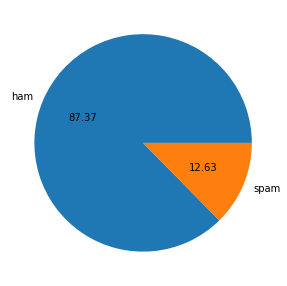

In [18]:
plt.figure(figsize = [10,5])
plt.pie(df['target'].value_counts(), labels= ['ham', 'spam'], autopct='%0.2f')
plt.show()

In [19]:
df['num_characters'] = df['text'].apply(len)

In [20]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [21]:
df['num_words'] = df['text'].apply(lambda x : len(nltk.word_tokenize(x)))

In [22]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [23]:
df['num_sentences'] = df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
df.head(5)

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [24]:
df[['num_characters','num_words','num_sentences']].describe() # to get the insights of data

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.923776,18.456375,1.962275
std,58.174846,13.323322,1.433892
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [25]:
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.456820,17.123339,1.815545
std,56.356802,13.491315,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.977029
std,30.014336,7.011513,1.493676
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<AxesSubplot:xlabel='num_characters', ylabel='Count'>

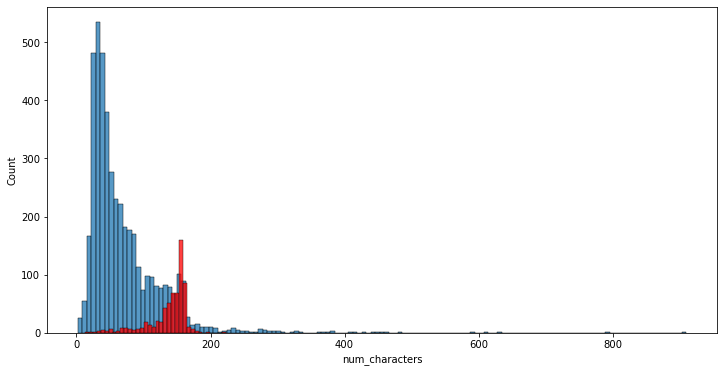

In [27]:
plt.figure(figsize =(12,6))
sns.histplot(df[df['target'] == 0]['num_characters']);
sns.histplot(df[df['target'] == 1]['num_characters'], color = 'red')

<AxesSubplot:xlabel='num_words', ylabel='Count'>

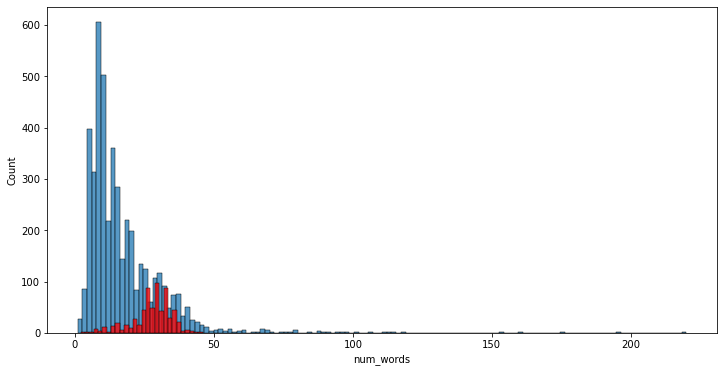

In [28]:
plt.figure(figsize =(12,6))
sns.histplot(df[df['target'] == 0]['num_words']);
sns.histplot(df[df['target'] == 1]['num_words'], color = 'red')

<AxesSubplot:xlabel='num_sentences', ylabel='Count'>

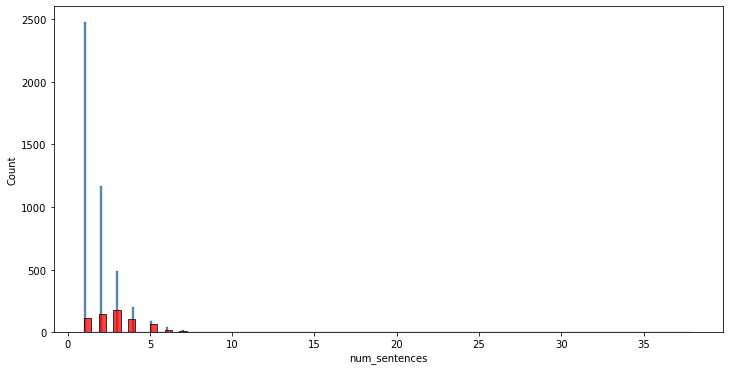

In [29]:
plt.figure(figsize =(12,6))
sns.histplot(df[df['target'] == 0]['num_sentences']);
sns.histplot(df[df['target'] == 1]['num_sentences'], color = 'red')

<Figure size 2160x1080 with 0 Axes>

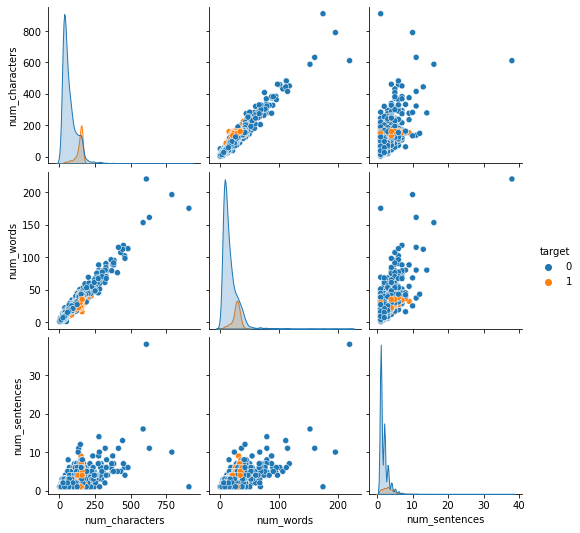

In [31]:
plt.figure(figsize = [30,15])
sns.pairplot(df, hue='target')

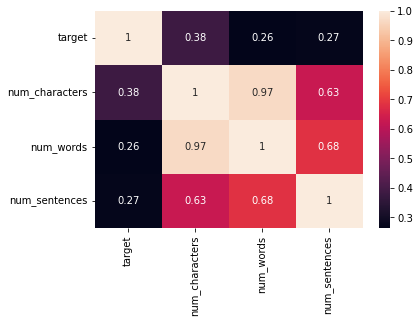

In [32]:
df.corr()
sns.heatmap(df.corr(), annot = True); # will keep num characters cokumn

In [33]:
from nltk.corpus import stopwords  
from nltk.stem.porter import PorterStemmer  
ps = PorterStemmer()

In [34]:
import string
#string.punctuation

In [35]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]  # Copying list we have to clone it 
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)

In [36]:
transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [37]:
df['transformed_text'] = df['text'].apply(transform_text)

In [38]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [39]:
from wordcloud import WordCloud
wc = WordCloud(width = 500, height = 500, min_font_size=10, background_color='white')

In [40]:
spam_wc = wc.generate(df[df['target']==1]['transformed_text'].str.cat(sep = " "))

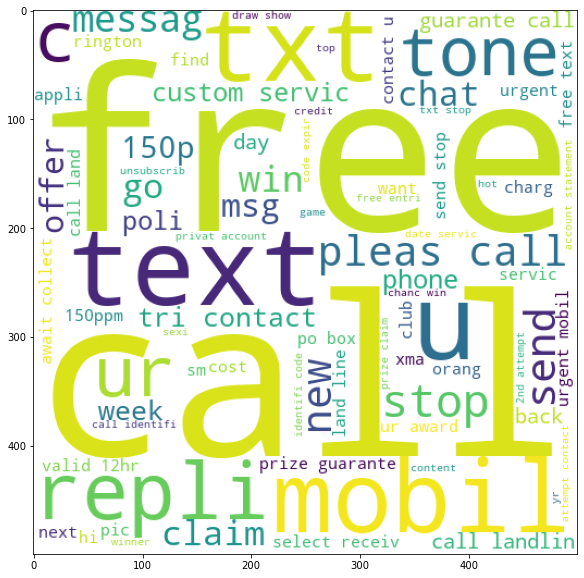

In [41]:
plt.figure(figsize=(30,10))
plt.imshow(spam_wc)

In [42]:
ham_wc = wc.generate(df[df['target']==0]['transformed_text'].str.cat(sep = " "))

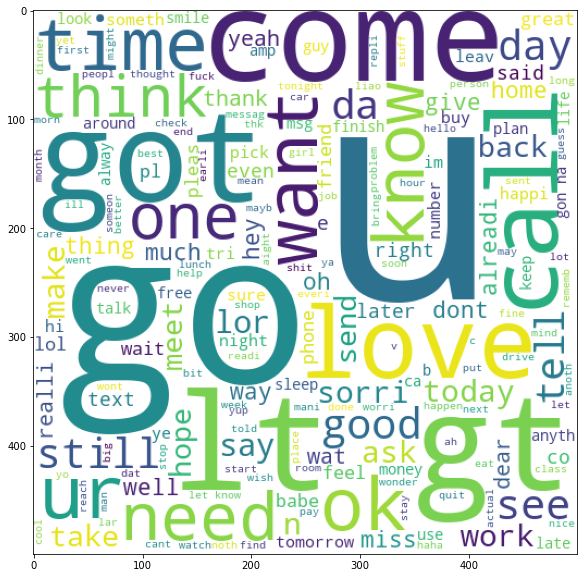

In [43]:
plt.figure(figsize=(30,10))
plt.imshow(ham_wc)

In [44]:
df.head(10)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though
5,1,FreeMsg Hey there darling it's been 3 week's n...,147,39,4,freemsg hey darl 3 week word back like fun sti...
6,0,Even my brother is not like to speak with me. ...,77,18,2,even brother like speak treat like aid patent
7,0,As per your request 'Melle Melle (Oru Minnamin...,160,31,2,per request mell oru minnaminungint nurungu ve...
8,1,WINNER!! As a valued network customer you have...,157,32,5,winner valu network custom select receivea pri...
9,1,Had your mobile 11 months or more? U R entitle...,154,31,3,mobil 11 month u r entitl updat latest colour ...


In [45]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [46]:
len(spam_corpus)

9941

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'call'),
  Text(1, 0, 'free'),
  Text(2, 0, '2'),
  Text(3, 0, 'txt'),
  Text(4, 0, 'text'),
  Text(5, 0, 'u'),
  Text(6, 0, 'ur'),
  Text(7, 0, 'mobil'),
  Text(8, 0, 'stop'),
  Text(9, 0, 'repli'),
  Text(10, 0, 'claim'),
  Text(11, 0, '4'),
  Text(12, 0, 'prize'),
  Text(13, 0, 'get'),
  Text(14, 0, 'new'),
  Text(15, 0, 'servic'),
  Text(16, 0, 'tone'),
  Text(17, 0, 'send'),
  Text(18, 0, 'urgent'),
  Text(19, 0, 'nokia'),
  Text(20, 0, 'contact'),
  Text(21, 0, 'award'),
  Text(22, 0, 'phone'),
  Text(23, 0, 'cash'),
  Text(24, 0, 'pleas'),
  Text(25, 0, 'week'),
  Text(26, 0, 'win'),
  Text(27, 0, 'c'),
  Text(28, 0, 'collect'),
  Text(29, 0, 'min')])

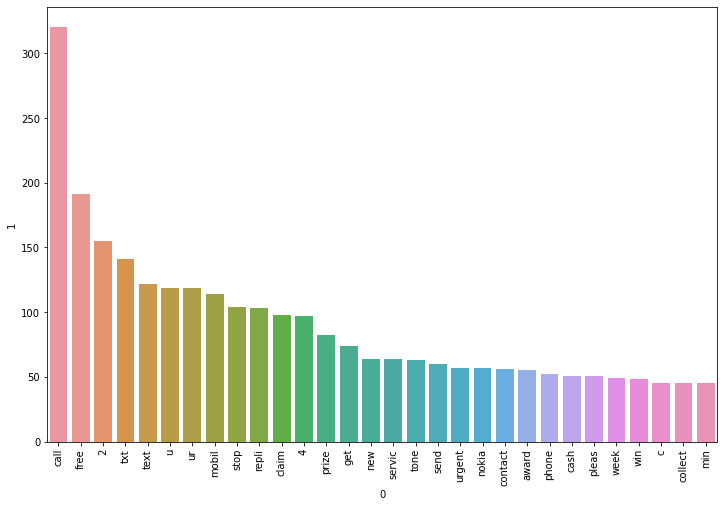

In [47]:
from collections import Counter
plt.figure(figsize=(12,8))
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')

In [48]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [49]:
len(ham_corpus)

35303

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'u'),
  Text(1, 0, 'go'),
  Text(2, 0, 'get'),
  Text(3, 0, 'gt'),
  Text(4, 0, 'lt'),
  Text(5, 0, '2'),
  Text(6, 0, 'come'),
  Text(7, 0, 'got'),
  Text(8, 0, 'know'),
  Text(9, 0, 'like'),
  Text(10, 0, 'call'),
  Text(11, 0, 'time'),
  Text(12, 0, 'love'),
  Text(13, 0, 'ok'),
  Text(14, 0, 'good'),
  Text(15, 0, 'want'),
  Text(16, 0, 'ur'),
  Text(17, 0, 'day'),
  Text(18, 0, 'need'),
  Text(19, 0, 'one'),
  Text(20, 0, 'lor'),
  Text(21, 0, '4'),
  Text(22, 0, 'home'),
  Text(23, 0, 'think'),
  Text(24, 0, 'see'),
  Text(25, 0, 'take'),
  Text(26, 0, 'still'),
  Text(27, 0, 'da'),
  Text(28, 0, 'tell'),
  Text(29, 0, 'make')])

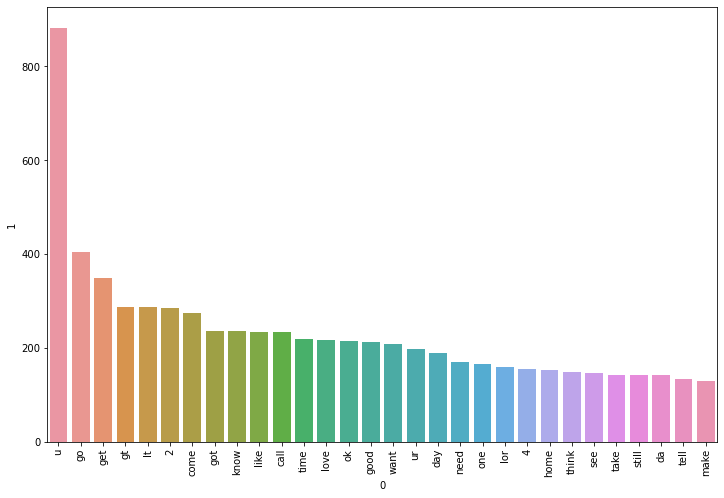

In [50]:
plt.figure(figsize=(12,8))
sns.barplot(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation = 'vertical')

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [52]:
X = tfidf.fit_transform(df['transformed_text']).toarray()  # it gives sparse array --> convert to dense array

In [53]:
X.shape

(5169, 3000)

In [54]:
y = df['target'].values

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [56]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [57]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [58]:
gnb.fit(X_train, y_train)  # low precision model 
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8704061895551257
[[788 108]
 [ 26 112]]
0.509090909090909


In [59]:
mnb.fit(X_train, y_train)  # imbalanced data precision data as high we can get not accuracy 
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.971953578336557
[[896   0]
 [ 29 109]]
1.0


In [60]:
bnb.fit(X_train, y_train)  # high precision model and better accuracy
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9835589941972921
[[895   1]
 [ 16 122]]
0.991869918699187


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty = 'l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

In [64]:
clfs = {
    'SVC': svc,
    'KN':knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF':rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT': gbdt
}

In [65]:
def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return accuracy, precision

In [66]:
train_classifier(svc, X_train, y_train)

(0.9748549323017408, 0.9745762711864406)

In [67]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X_train, y_train)
    print("For", name)
    print("Accuracy", current_accuracy)
    print("Precision", current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For SVC
Accuracy 0.9748549323017408
Precision 0.9745762711864406
For KN
Accuracy 0.9052224371373307
Precision 1.0
For NB
Accuracy 0.971953578336557
Precision 1.0
For DT
Accuracy 0.9313346228239845
Precision 0.8252427184466019
For LR
Accuracy 0.9564796905222437
Precision 0.9696969696969697
For RF
Accuracy 0.9758220502901354
Precision 0.9829059829059829
For AdaBoost
Accuracy 0.9613152804642167
Precision 0.9454545454545454
For BgC
Accuracy 0.9593810444874274
Precision 0.8692307692307693
For ETC
Accuracy 0.9796905222437138
Precision 0.975609756097561
For GBDT
Accuracy 0.9468085106382979
Precision 0.9278350515463918


In [68]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy': accuracy_scores, 'Precision': precision_scores }).sort_values('Precision',ascending=False)

In [69]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.971954,1.000000
5,RF,0.975822,0.982906
8,ETC,0.979691,0.975610
0,SVC,0.974855,0.974576
4,LR,0.956480,0.969697
6,AdaBoost,0.961315,0.945455
9,GBDT,0.946809,0.927835
7,BgC,0.959381,0.869231
3,DT,0.931335,0.825243


In [70]:
performance_df1 = pd.melt(performance_df, id_vars='Algorithm')

In [71]:
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.905222
1,NB,Accuracy,0.971954
2,RF,Accuracy,0.975822
3,ETC,Accuracy,0.979691
4,SVC,Accuracy,0.974855
5,LR,Accuracy,0.956480
6,AdaBoost,Accuracy,0.961315
7,GBDT,Accuracy,0.946809
8,BgC,Accuracy,0.959381
9,DT,Accuracy,0.931335


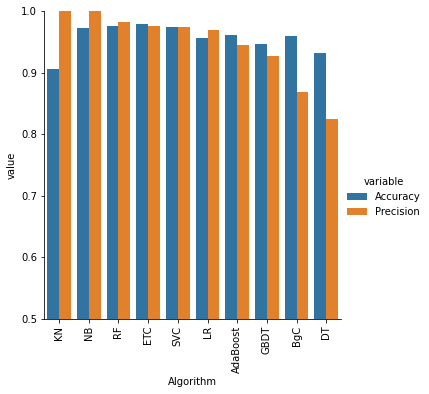

In [72]:
sns.catplot(x = 'Algorithm', y='value',
           hue = 'variable', data=performance_df1, kind = 'bar', height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [73]:
svc = SVC(kernel='sigmoid', gamma=1.0, probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
from sklearn.ensemble import VotingClassifier

In [74]:
voting  = VotingClassifier(estimators=[('svm',svc), ('nb', mnb), ('et',etc)], voting='soft') # Weithage is equal for all algorithms

In [75]:
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svm',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [76]:
y_pred = voting.predict(X_test)
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test,y_pred))

Accuracy 0.9816247582205029
Precision 0.9917355371900827


In [77]:
# applying stacking  ---> give weightage using a final estiamtor
estimators = [('svm', svc), ('nb', mnb), ('et',etc)]
final_estimator = RandomForestClassifier()

In [78]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators = estimators, final_estimator = final_estimator)

In [79]:
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy", accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9398496240601504


In [80]:
import pickle
pickle.dump(tfidf, open('vecotizer.pkl','wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))